# Running a baroclinic instability test case

First we set up the mpi environment:

In [1]:
import ipyparallel as ipp
ntiles = 6
layout = (1, 1)

num_ranks = ntiles * layout[0] * layout[1]
cluster = ipp.Cluster(engines="mpi", n=num_ranks).start_and_connect_sync()

# start executing cells on the workers in parallel from here on
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|███████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.08engine/s]
%autopx enabled


Double-check the MPI setup:

In [2]:
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
mpi_size = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

print(f"I am MPI-rank {mpi_rank} of a total of {mpi_size}")

[stdout:1] I am MPI-rank 1 of a total of 6


[stdout:5] I am MPI-rank 5 of a total of 6


[stdout:3] I am MPI-rank 3 of a total of 6


[stdout:2] I am MPI-rank 2 of a total of 6


[stdout:0] I am MPI-rank 0 of a total of 6


[stdout:4] I am MPI-rank 4 of a total of 6


Next we set up the model driver using the yaml config file:

In [3]:
%%capture

from pace import Driver, DriverConfig
import yaml

config_file = "baroclinic_c20.yaml"

with open(config_file, "r") as f:
    driver_config = DriverConfig.from_dict(yaml.safe_load(f))
driver = Driver(config=driver_config)

%px: 100%|███████████████████████████████████████████████████| 6/6 [03:10<00:00, 31.74s/tasks]


In [4]:
if mpi_rank == 0:
    print(driver.state.grid_data.lon_agrid.shape)

[stdout:0] (27, 27)


We can inspect the initial model state:

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube
from ndsl import CubedSphereCommunicator

communicator = CubedSphereCommunicator.from_layout(
    comm=driver.comm,
    layout=driver.config.layout,
)
u_wind = communicator.gather(driver.state.dycore_state.u)
temperature = communicator.gather(driver.state.dycore_state.pt)
surface_pressure = communicator.gather(driver.state.dycore_state.ps)
grid_lon = communicator.gather(driver.state.grid_data.lon)
grid_lat = communicator.gather(driver.state.grid_data.lat)
a_lon = communicator.gather(driver.state.grid_data.lon_agrid)
a_lat = communicator.gather(driver.state.grid_data.lat_agrid)

[output:0]

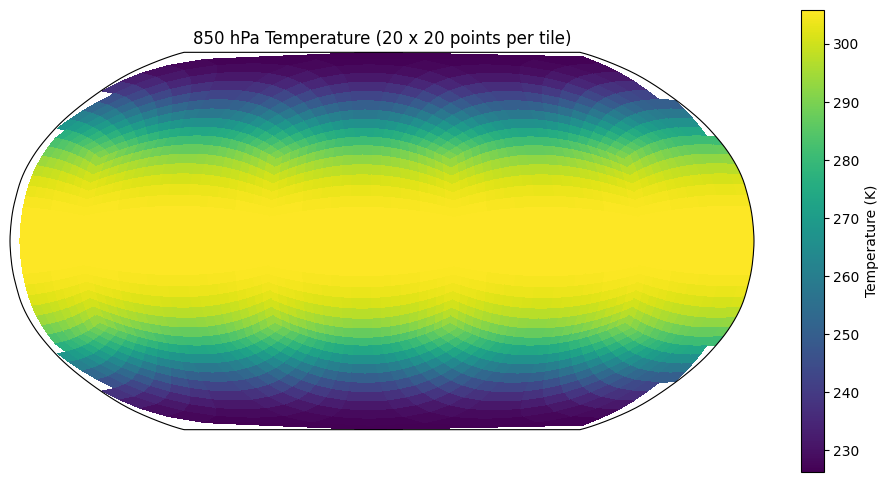

In [6]:
if mpi_rank == 0:
    u_mean = 0.5 * (u_wind.data[:,:,:-1, :] + u_wind.data[:,:, 1:, :])
    
    nx = temperature.shape[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(
        grid_lat.data * 180./np.pi,
        grid_lon.data * 180./np.pi,
        temperature.data[:, :, :, -2],
        cmap="viridis",
    )
    plt.colorbar(f1, label="Temperature (K)")
    ax.set_title(f"850 hPa Temperature ({nx} x {nx} points per tile)")
    
#     fig = plt.figure(figsize=(12, 6))
#     ax = fig.add_subplot(111, projection=ccrs.Robinson())
#     f1 = pcolormesh_cube(
#         grid_lat.data * 180./np.pi,
#         grid_lon.data * 180./np.pi,
#         surface_pressure.data[:, :, :]/100.,
#         cmap="viridis",
#     )
#     plt.colorbar(f1, label="Surface Pressure (hPa)")
#     ax.set_title(f"Surface Pressure ({nx} x {nx} points per tile)")
    
    
#     fig = plt.figure(figsize=(12, 6))
#     ax = fig.add_subplot(111, projection=ccrs.Robinson())
#     f1 = pcolormesh_cube(
#         grid_lat.data * 180./np.pi,
#         grid_lon.data * 180./np.pi,
#         u_mean[:,:,:,65],
#         cmap="bwr",
#     )
#     plt.colorbar(f1, label="U wind (m/s)")
#     ax.set_title(f"U Wind ({nx} x {nx} points per tile)")

And then we can run the model:

In [7]:
try:
    driver.step_all()
finally:
    driver.cleanup()

%px: 100%|███████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.77s/tasks]


Now let's investigate the model state

In [8]:
u_wind = communicator.gather(driver.state.dycore_state.u)
temperature = communicator.gather(driver.state.dycore_state.pt)
surface_pressure = communicator.gather(driver.state.dycore_state.ps)
grid_lon = communicator.gather(driver.state.grid_data.lon)
grid_lat = communicator.gather(driver.state.grid_data.lat)
a_lon = communicator.gather(driver.state.grid_data.lon_agrid)
a_lat = communicator.gather(driver.state.grid_data.lat_agrid)
qvap = communicator.gather(driver.state.dycore_state.qvapor)
qcld = communicator.gather(driver.state.dycore_state.qcld)
qrain = communicator.gather(driver.state.dycore_state.qrain)

[output:0]

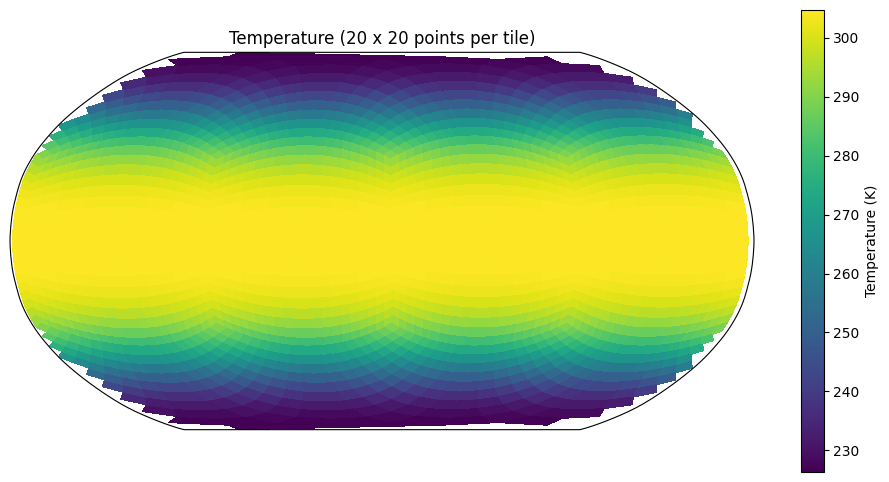

[output:0]

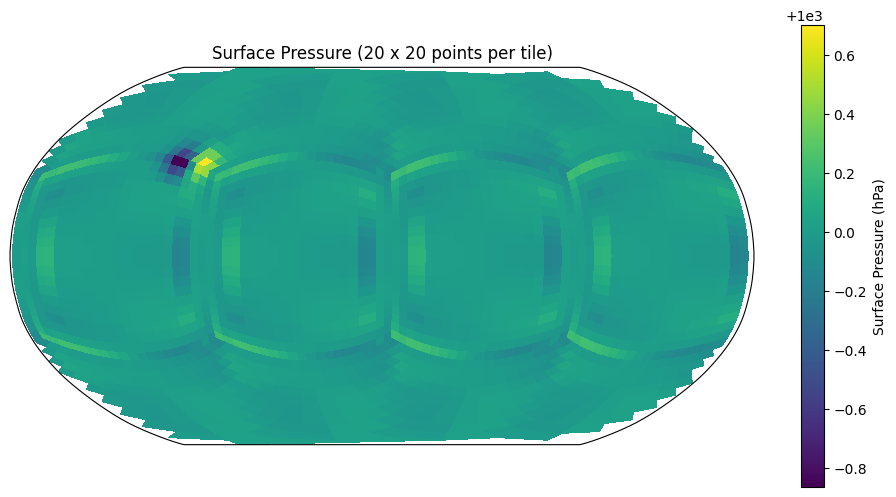

[output:0]

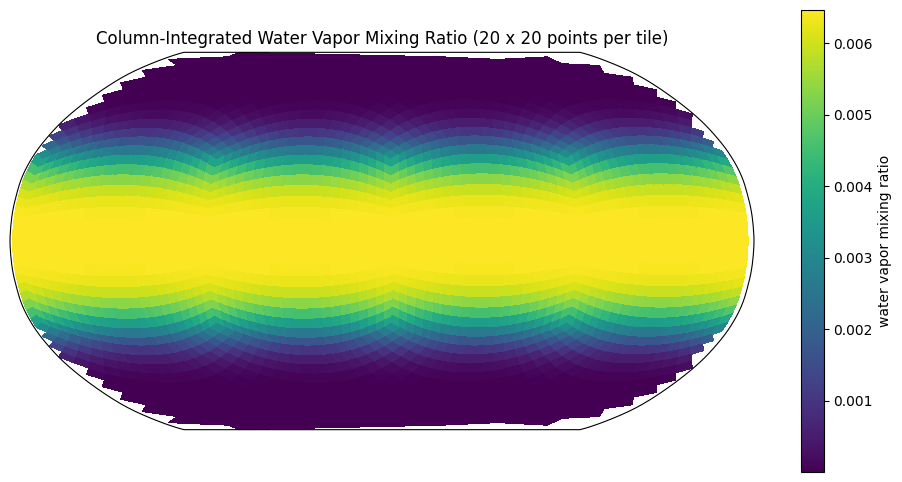

[output:0]

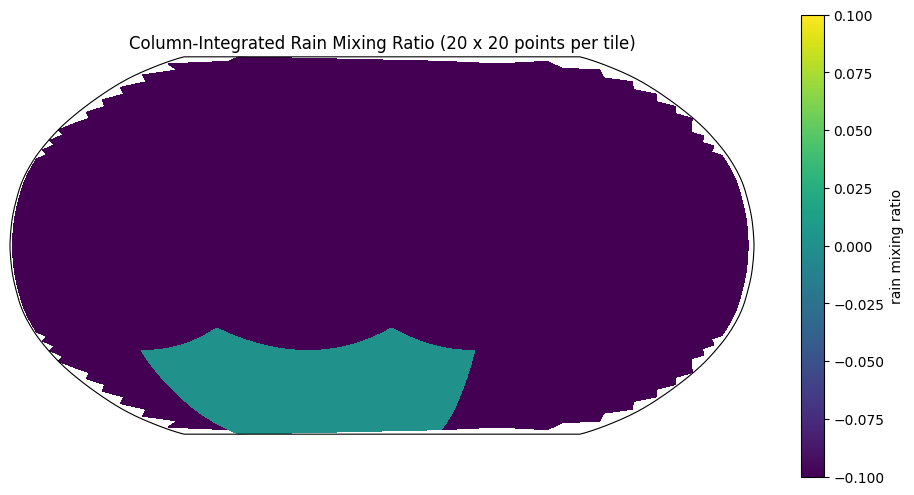

[output:0]

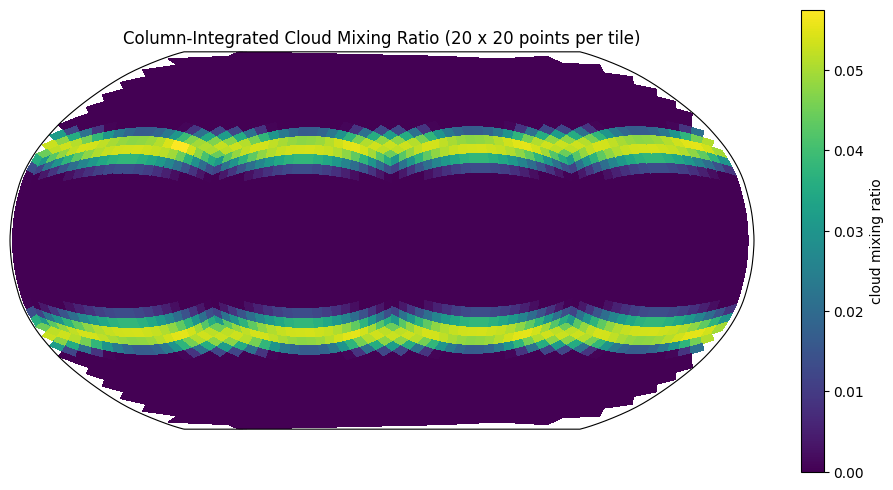

In [9]:
if mpi_rank == 0:
    rotation = -120.
    nx = temperature.shape[1]
    nz = temperature.shape[3]
    
    u_mean = 0.5 * (u_wind.data[:,:,:-1, :] + u_wind.data[:,:, 1:, :])
    column_qvap = np.sum(qvap, axis=3)/nz
    column_qcld = np.sum(qcld, axis=3)/nz
    column_qrain = np.sum(qrain, axis=3)/nz
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(
        grid_lat.data * 180./np.pi,
        grid_lon.data * 180./np.pi + rotation,
        temperature.data[:, :, :, -2],
        cmap="viridis",
    )
    plt.colorbar(f1, label="Temperature (K)")
    ax.set_title(f"Temperature ({nx} x {nx} points per tile)")
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(
        grid_lat.data * 180./np.pi,
        grid_lon.data * 180./np.pi + rotation,
        surface_pressure.data[:, :, :]/100.,
        cmap="viridis",
    )
    plt.colorbar(f1, label="Surface Pressure (hPa)")
    ax.set_title(f"Surface Pressure ({nx} x {nx} points per tile)")
    
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(
        grid_lat.data * 180./np.pi,
        grid_lon.data * 180./np.pi + rotation,
        column_qvap,
        cmap="viridis",
    )
    plt.colorbar(f1, label="water vapor mixing ratio")
    ax.set_title(f"Column-Integrated Water Vapor Mixing Ratio ({nx} x {nx} points per tile)")
    

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(
        grid_lat.data * 180./np.pi,
        grid_lon.data * 180./np.pi + rotation,
        column_qrain,
        cmap="viridis",
    )
    plt.colorbar(f1, label="rain mixing ratio")
    ax.set_title(f"Column-Integrated Rain Mixing Ratio ({nx} x {nx} points per tile)")
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(
        grid_lat.data * 180./np.pi,
        grid_lon.data * 180./np.pi + rotation,
        column_qcld,
        cmap="viridis",
    )
    plt.colorbar(f1, label="cloud mixing ratio")
    ax.set_title(f"Column-Integrated Cloud Mixing Ratio ({nx} x {nx} points per tile)")